In [0]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [37]:
df = pd.read_csv('user_reviews.csv')
df.head()

,grade,user_name,text,date
0,4,mds27272,My gf started playing before me. No option to ...,2020-03-20
1,5,lolo2178,"While the game itself is great, really relaxin...",2020-03-20
2,0,Roachant,My wife and I were looking forward to playing ...,2020-03-20
3,0,Houndf,We need equal values and opportunities for all...,2020-03-20
4,0,ProfessorFox,BEWARE! If you have multiple people in your h...,2020-03-20


In [0]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])

In [0]:
nlp = spacy.load('en', disable=['ner', 'parser'])
def cleaning(doc):
    txt = [token.text for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [45]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.22 mins


In [48]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(2980, 1)


                                               clean
0  gf started playing option create island guys n...
1  game great relaxing gorgeous ignore thing ruin...
2  wife looking forward playing game released bou...
3  need equal values opportunities players island...
4  beware multiple people house want play game ac...


In [0]:
from gensim.models.phrases import Phrases, Phraser

In [0]:
sent = [row.split() for row in df_clean['clean']]

In [51]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

2020-05-27 15:24:38,071 : INFO : collecting all words and their counts
2020-05-27 15:24:38,073 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-05-27 15:24:38,382 : INFO : collected 89593 word types from a corpus of 158510 words (unigram + bigrams) and 2980 sentences
2020-05-27 15:24:38,384 : INFO : using 89593 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [0]:
sentences = bigram[sent]

In [53]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

11100

In [54]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['game',
 'island',
 'switch',
 'play',
 'player',
 'nintendo',
 'console',
 'expand',
 'like',
 'animal_crossing']

In [0]:
import multiprocessing

from gensim.models import Word2Vec

In [0]:
cores = multiprocessing.cpu_count()

In [0]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [59]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

2020-05-27 15:29:15,075 : INFO : collecting all words and their counts
2020-05-27 15:29:15,076 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-27 15:29:15,547 : INFO : collected 11100 word types from a corpus of 155287 raw words and 2980 sentences
2020-05-27 15:29:15,549 : INFO : Loading a fresh vocabulary
2020-05-27 15:29:15,566 : INFO : effective_min_count=20 retains 1126 unique words (10% of original 11100, drops 9974)
2020-05-27 15:29:15,567 : INFO : effective_min_count=20 leaves 124006 word corpus (79% of original 155287, drops 31281)
2020-05-27 15:29:15,579 : INFO : deleting the raw counts dictionary of 11100 items
2020-05-27 15:29:15,580 : INFO : sample=6e-05 downsamples 1126 most-common words
2020-05-27 15:29:15,581 : INFO : downsampling leaves estimated 34889 word corpus (28.1% of prior 124006)
2020-05-27 15:29:15,587 : INFO : estimated required memory for 1126 words and 300 dimensions: 3265400 bytes
2020-05-27 15:29:15,588 : INFO : resetting

Time to build vocab: 0.01 mins


In [0]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [61]:
w2v_model.init_sims(replace=True)

2020-05-27 15:30:25,042 : INFO : precomputing L2-norms of word weight vectors


In [62]:
w2v_model.wv.most_similar(positive=["nintendo"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('switch', 0.9616822004318237),
 ('save', 0.9597688317298889),
 ('data', 0.9316975474357605),
 ('consoles', 0.9191608428955078),
 ('console', 0.9182857275009155),
 ('consumer', 0.9181947708129883),
 ('anti', 0.9150808453559875),
 ('transfer', 0.9072661995887756),
 ('ea', 0.9070701599121094),
 ('company', 0.9025524854660034)]

In [63]:
w2v_model.wv.most_similar(positive=["animal_crossing"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('fan', 0.9835084676742554),
 ('ac', 0.9808158278465271),
 ('new_horizons', 0.9801082611083984),
 ('attention', 0.9750741720199585),
 ('gamecube', 0.9722132682800293),
 ('favorite', 0.9716711640357971),
 ('installment', 0.9692897200584412),
 ('far', 0.9683687686920166),
 ('franchise', 0.9665664434432983),
 ('date', 0.9653702974319458)]

In [64]:
w2v_model.wv.similarity("nintendo", 'animal_crossing')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.47569913

In [65]:
w2v_model.wv.similarity("nintendo", 'switch')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.961682

In [66]:
w2v_model.wv.doesnt_match(['nintendo', 'switch', 'good'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'good'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [0]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Ten most similar words and eight random words I chose

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


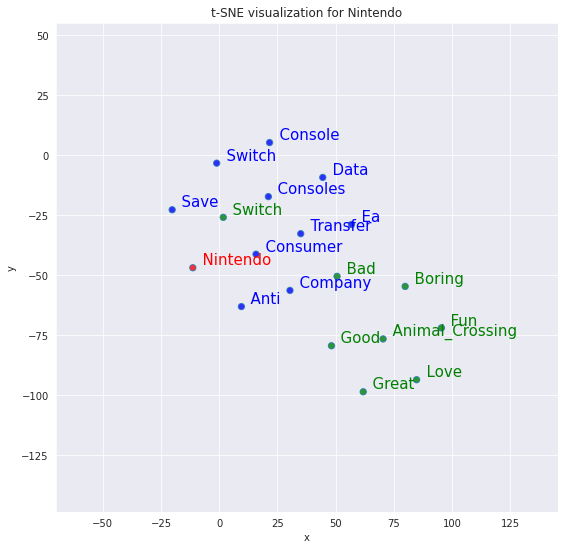

In [71]:
tsnescatterplot(w2v_model, 'nintendo', ['switch', 'animal_crossing', 'good', 'bad', 'boring', 'great', 'love', 'fun'])

10 most similar words against 10 most dissimilar

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


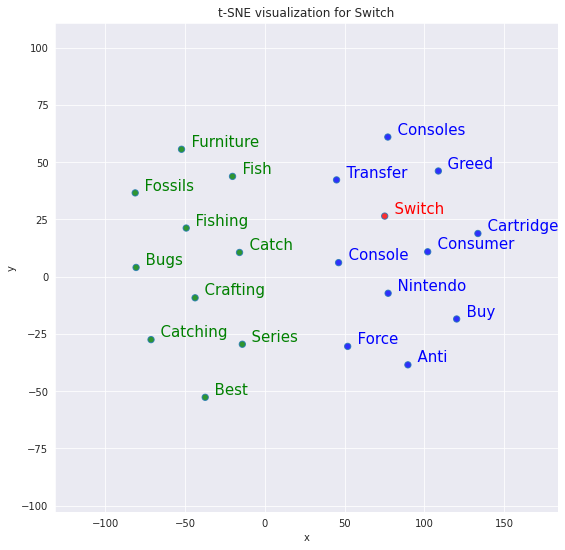

In [72]:
tsnescatterplot(w2v_model, 'switch', [i[0] for i in w2v_model.wv.most_similar(negative=["switch"])])